In [1]:
# type: ignore
import numpy as np
import pandas as pd
import os
import sys
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [2]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
!unzip /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24.zip -d /kaggle/input/ravdess-emotional-speech-audio/

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
# Paths for data.
# Ravdess = "/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "./AudioWAV/"
Tess = "./TESS Toronto emotional speech set data/"
Savee = "./ALL/"
Ravdess = "./RAVDESS/"

In [5]:
ravdess_directory_list = os.listdir(Ravdess)

In [6]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,./RAVDESS/Actor_01/03-01-01-01-01-01-01.wav
1,neutral,./RAVDESS/Actor_01/03-01-01-01-01-02-01.wav
2,neutral,./RAVDESS/Actor_01/03-01-01-01-02-01-01.wav
3,neutral,./RAVDESS/Actor_01/03-01-01-01-02-02-01.wav
4,calm,./RAVDESS/Actor_01/03-01-02-01-01-01-01.wav


In [7]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,angry,./AudioWAV/1001_DFA_ANG_XX.wav
1,disgust,./AudioWAV/1001_DFA_DIS_XX.wav
2,fear,./AudioWAV/1001_DFA_FEA_XX.wav
3,happy,./AudioWAV/1001_DFA_HAP_XX.wav
4,neutral,./AudioWAV/1001_DFA_NEU_XX.wav


In [8]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,angry,./TESS Toronto emotional speech set data/OAF_a...
1,angry,./TESS Toronto emotional speech set data/OAF_a...
2,angry,./TESS Toronto emotional speech set data/OAF_a...
3,angry,./TESS Toronto emotional speech set data/OAF_a...
4,angry,./TESS Toronto emotional speech set data/OAF_a...


In [9]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,angry,./ALL/DC_a01.wav
1,angry,./ALL/DC_a02.wav
2,angry,./ALL/DC_a03.wav
3,angry,./ALL/DC_a04.wav
4,angry,./ALL/DC_a05.wav


In [10]:
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,./RAVDESS/Actor_01/03-01-01-01-01-01-01.wav
1,neutral,./RAVDESS/Actor_01/03-01-01-01-01-02-01.wav
2,neutral,./RAVDESS/Actor_01/03-01-01-01-02-01-01.wav
3,neutral,./RAVDESS/Actor_01/03-01-01-01-02-02-01.wav
4,calm,./RAVDESS/Actor_01/03-01-02-01-01-01-01.wav


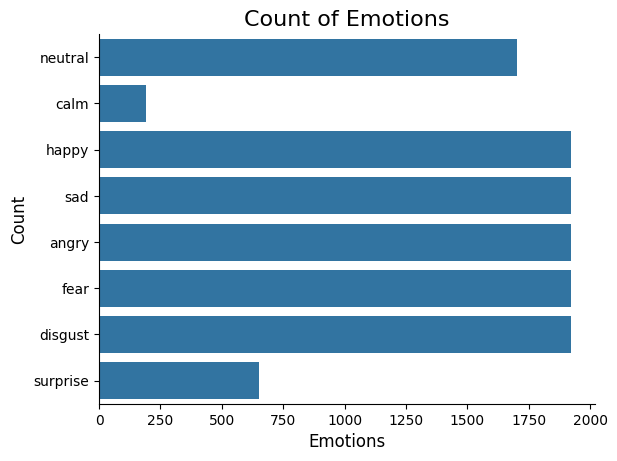

In [11]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [12]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [13]:
import matplotlib.pyplot as plt

# Load the audio file
data, sampling_rate = librosa.load(path)

# Create a time array
time = np.arange(0, len(data)) / sampling_rate

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(time, data, color='b')
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


NameError: name 'path' is not defined

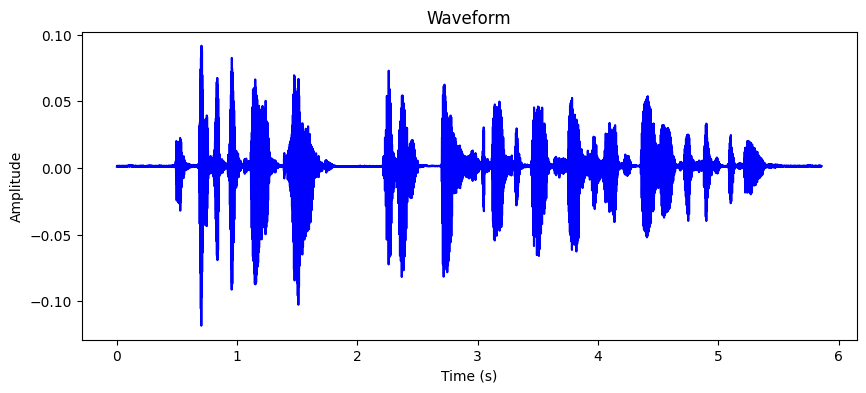

In [338]:
import matplotlib.pyplot as plt

# Load the audio file

data, sampling_rate = librosa.load(path)

# Create a time array
time = np.arange(0, len(data)) / sampling_rate

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(time, data, color='b')
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


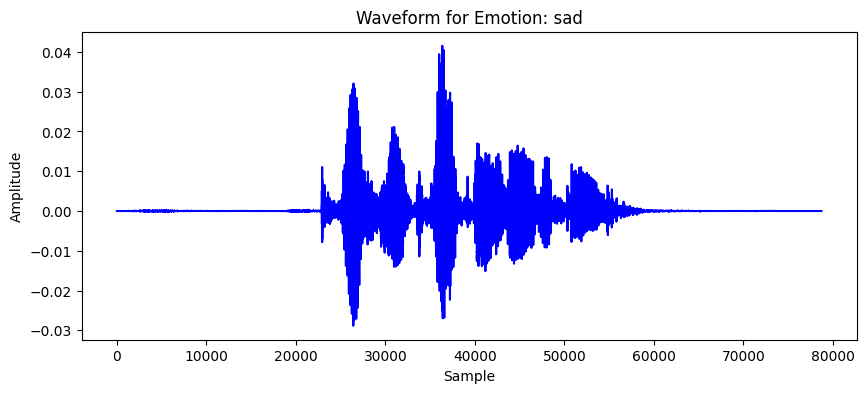

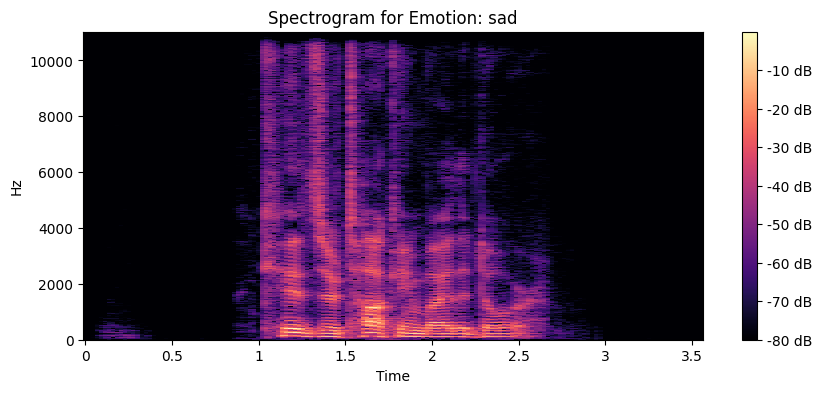

In [339]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)

# Create a waveform plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(data, color='b')
plt.title('Waveform for Emotion: ' + emotion)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

# Create a spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)

# Display the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram for Emotion: ' + emotion)
plt.show()

# Play the audio
from IPython.display import Audio
Audio(path)


In [340]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

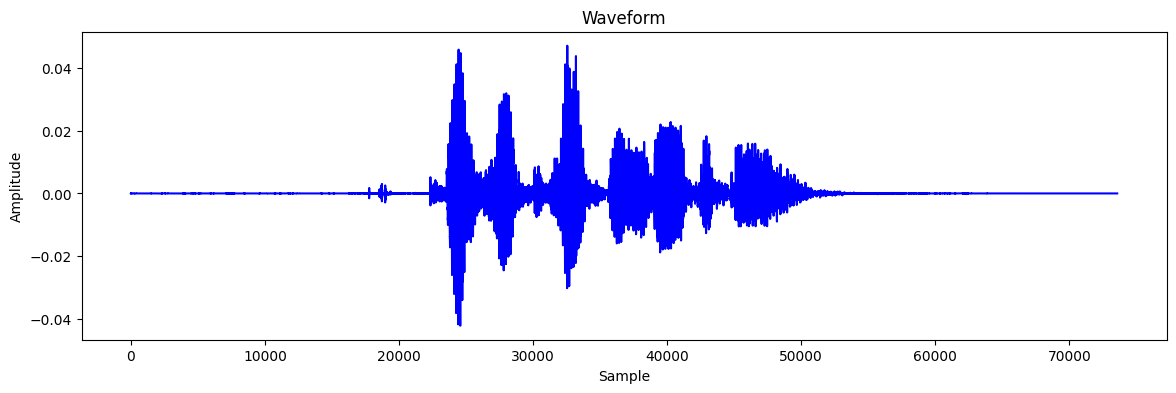

In [341]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
plt.plot(data, color='b')
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()
from IPython.display import Audio
Audio(path)


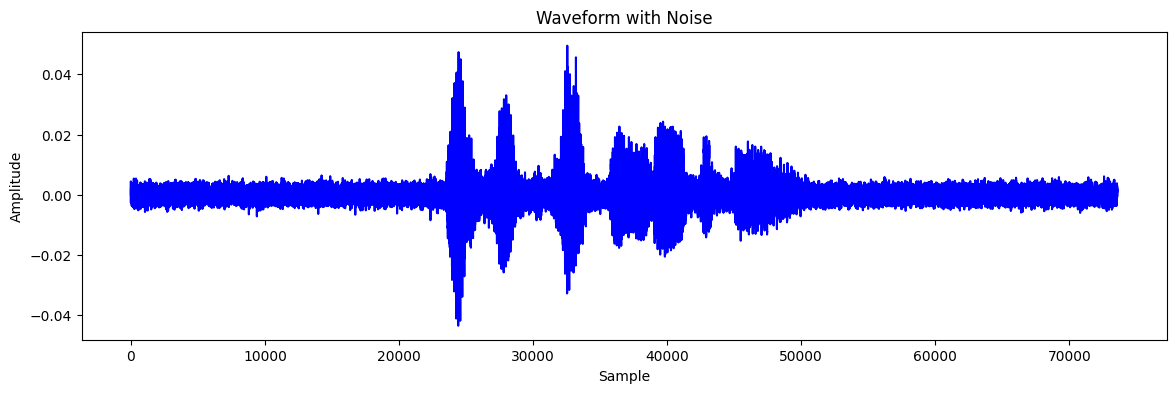

In [342]:
import matplotlib.pyplot as plt

# Assuming `noise` function adds noise to the data
x = noise(data)

plt.figure(figsize=(14, 4))
plt.plot(x, color='b')
plt.title('Waveform with Noise')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()
from IPython.display import Audio
Audio(x, rate=sample_rate)


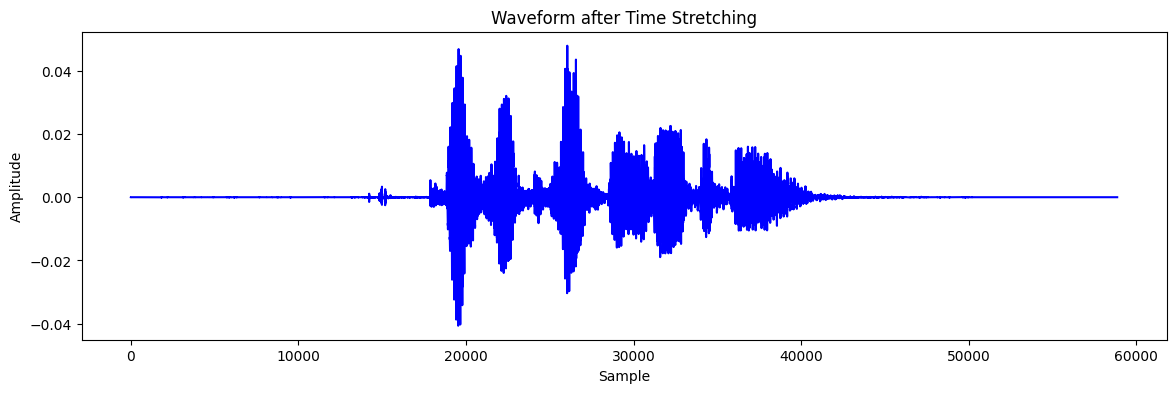

In [343]:
# Load the audio file with time stretching
data_stretched, sampling_rate_stretched = librosa.load(path, sr=sample_rate * 0.8)

# Plot the waveform of the stretched audio
plt.figure(figsize=(14, 4))
plt.plot(data_stretched, color='b')
plt.title('Waveform after Time Stretching')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

# Play the stretched audio
from IPython.display import Audio
Audio(data_stretched, rate=sampling_rate_stretched)


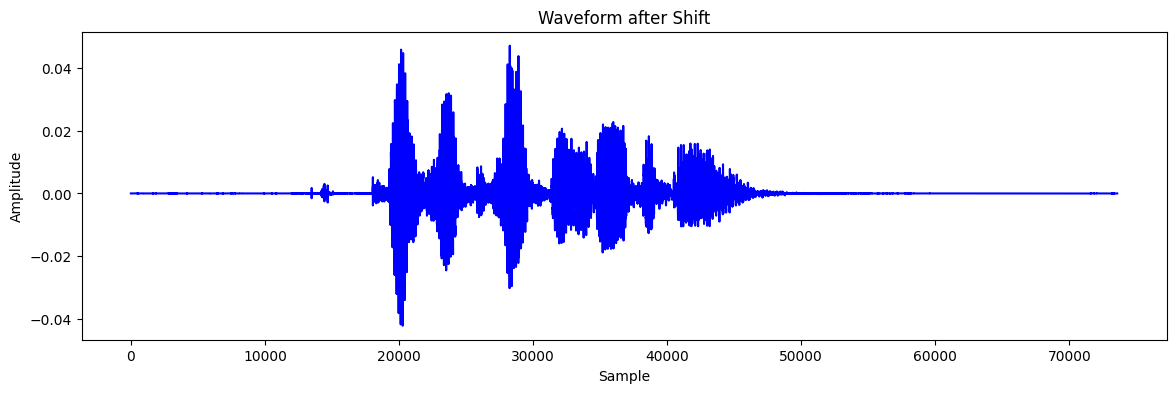

In [344]:
import matplotlib.pyplot as plt

# Assuming `shift` function shifts the data
x = shift(data)

plt.figure(figsize=(14, 4))
plt.plot(x, color='b')
plt.title('Waveform after Shift')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()


Audio(x, rate=sample_rate)


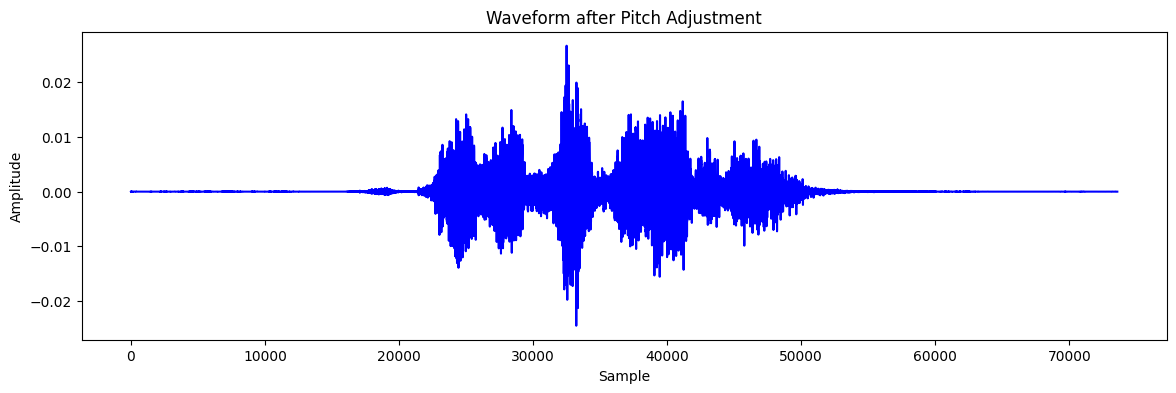

In [345]:
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

x = pitch(data, sample_rate)

plt.figure(figsize=(14, 4))
plt.plot(x, color='b')
plt.title('Waveform after Pitch Adjustment')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

from IPython.display import Audio
Audio(x, rate=sample_rate)


In [346]:
# Define functions for augmentation and feature extraction
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)


In [347]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result



In [348]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    data, _ = librosa.load(path, sr=44100) 
    data = np.asarray(data) 
    feature = extract_features(data, 44100) 
    for ele in feature:
        X.append(ele)
        Y.append(emotion)


In [349]:
len(X), len(Y), data_path.Path.shape

(1970244, 1970244, (12162,))

In [350]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,labels
0,0.322199,neutral
1,0.771437,neutral
2,0.792835,neutral
3,0.789363,neutral
4,0.781618,neutral


In [351]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [352]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [353]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1477683, 1), (1477683, 8), (492561, 1), (492561, 8))

In [354]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1477683, 1), (1477683, 8), (492561, 1), (492561, 8))

In [355]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1477683, 1, 1), (1477683, 8), (492561, 1, 1), (492561, 8))

In [356]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1, 256)            1536      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 1, 256)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 256)            327936    
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 1, 256)            0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 1, 128)            163968    
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 1, 128)           

In [357]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/10
23089/23089 [==============================] - 405s 17ms/step - loss: 1.9507 - accuracy: 0.1772 - val_loss: 1.9427 - val_accuracy: 0.1896 - lr: 0.0010
Epoch 2/10
23089/23089 [==============================] - 331s 14ms/step - loss: 1.9444 - accuracy: 0.1887 - val_loss: 1.9405 - val_accuracy: 0.1912 - lr: 0.0010
Epoch 3/10
23089/23089 [==============================] - 329s 14ms/step - loss: 1.9441 - accuracy: 0.1901 - val_loss: 1.9356 - val_accuracy: 0.2033 - lr: 0.0010
Epoch 4/10
23089/23089 [==============================] - 327s 14ms/step - loss: 1.9419 - accuracy: 0.1930 - val_loss: 1.9392 - val_accuracy: 0.1942 - lr: 0.0010
Epoch 5/10
23089/23089 [==============================] - 323s 14ms/step - loss: 1.9405 - accuracy: 0.1941 - val_loss: 1.9405 - val_accuracy: 0.1918 - lr: 0.0010
Epoch 6/10
23089/23089 [==============================] - 332s 14ms/step - loss: 1.9400 - accuracy: 0.1946 - val_loss: 1.9587 - val_accuracy: 0.1551 - lr: 0.0010
Epoch 7/10
23089/23089 [====

In [358]:
model.save("./trainedmodel.h5")

15393/15393 [==============================] - 39s 3ms/step - loss: 1.9329 - accuracy: 0.2029
Accuracy of our model on test data :  20.28621882200241 %


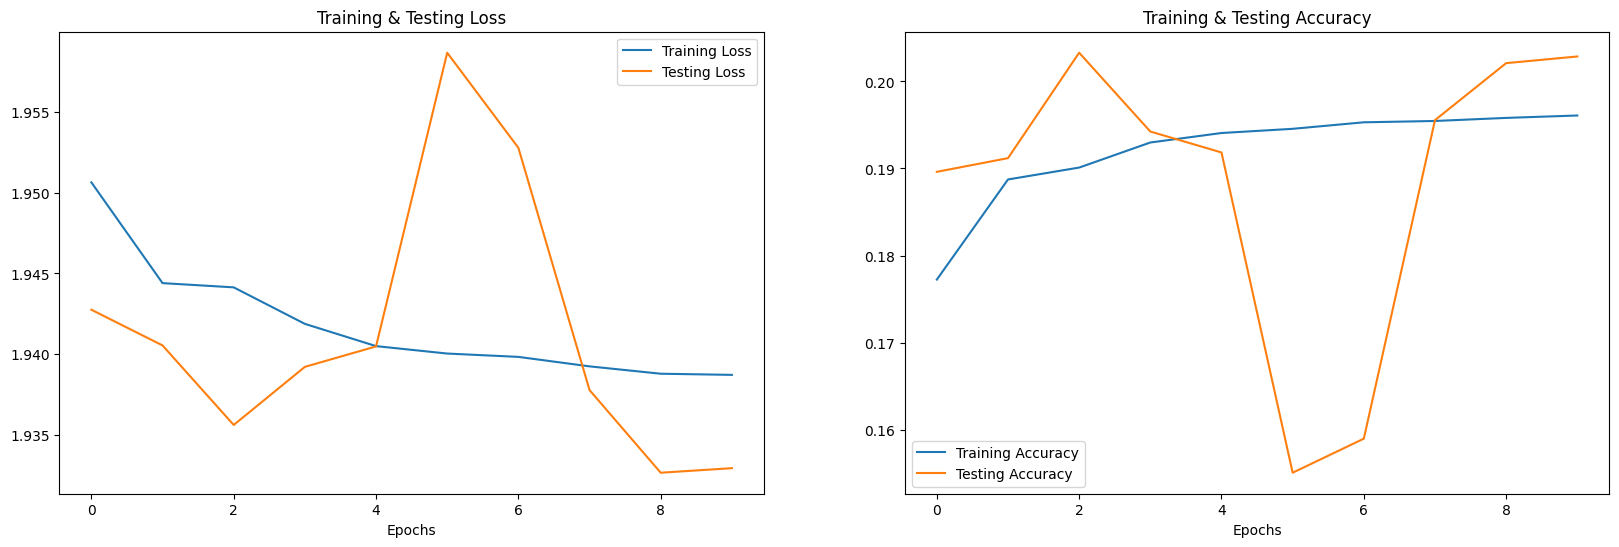

In [359]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [360]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

15393/15393 [==============================] - 40s 3ms/step


In [361]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,angry,sad
1,happy,angry
2,sad,disgust
3,angry,sad
4,happy,angry
5,sad,disgust
6,sad,neutral
7,sad,angry
8,sad,disgust
9,angry,happy


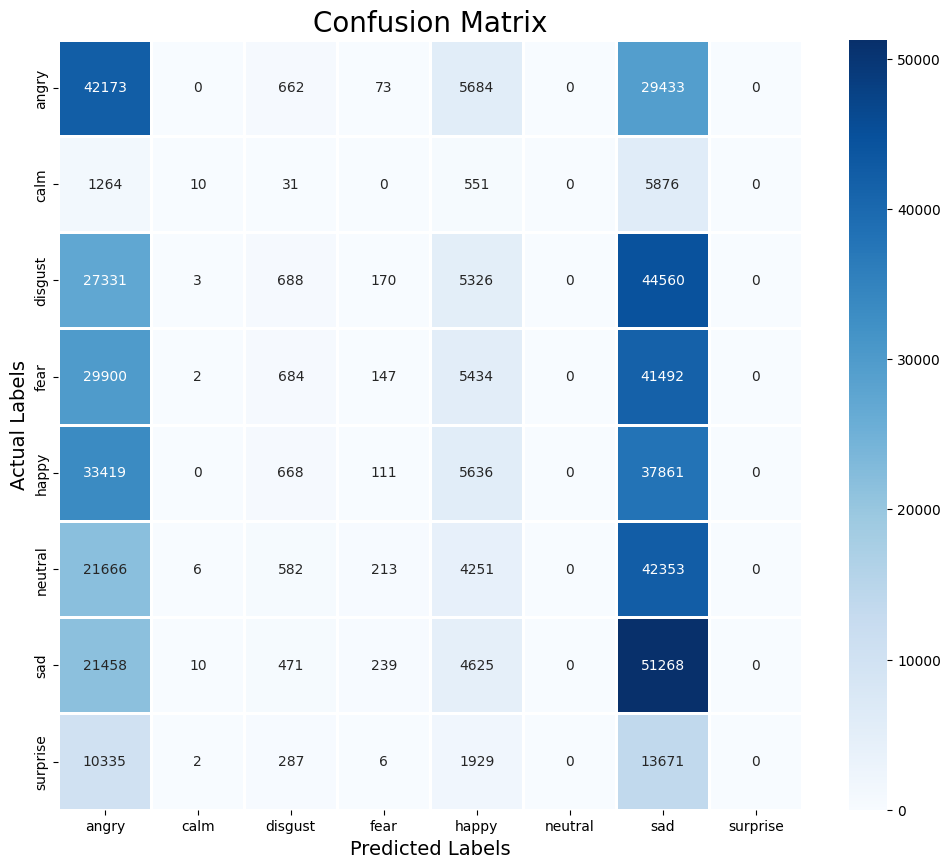

In [362]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [363]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.22      0.54      0.32     78025
        calm       0.30      0.00      0.00      7732
     disgust       0.17      0.01      0.02     78078
        fear       0.15      0.00      0.00     77659
       happy       0.17      0.07      0.10     77695
     neutral       0.00      0.00      0.00     69071
         sad       0.19      0.66      0.30     78071
    surprise       0.00      0.00      0.00     26230

    accuracy                           0.20    492561
   macro avg       0.15      0.16      0.09    492561
weighted avg       0.15      0.20      0.12    492561

